In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy.integrate import odeint
import scipy.interpolate as interpolate

from matplotlib import rc
rc('text', usetex=True)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = '#121212'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]
rc('font',**{'family':'serif','serif':['New Century Schoolbook']})

# For the rolling average
window_size = 7

In [2]:
######################################################
# The BSM ODE

def ODE_BSM(x, t, beta, k, a):
    return beta*x*(1 - x/k + a*x*x)

######################################################
# Functions to solve ODE

def ODE_BSM_sol(t, x0, beta, k, a):
    x = odeint(ODE_BSM, x0, t, args=(beta, k, a))
    return x.reshape(1,-1)[0]

######################################################
# Functions to get the gradient of the solved ODE

def ODE_BSM_grad(t, x0, beta, k, a):
    x = odeint(ODE_BSM, x0, t, args=(beta, k, a))
    return ODE_BSM(x.reshape(1,-1)[0], t, beta, k, a)

######################################################

def fitODE_grad(df, p0, model):
    df = df.sort_values(by=['X'])
    x_g = df['X'].values
    y_g = df['Y'].values
    if model == 'BSM':
        fit, covar = curve_fit(ODE_BSM_grad, x_g, y_g, p0=p0)
    return fit, covar

######################################################


def makeuniversal(df_c, country, startdate, datet_max, markers, plt, fact=1./2., label=True, alpha=1):
    df_p = pd.DataFrame()
    if len(country) != len(startdate):
        print('unequal input lists')
        exit(1)
    for i in range(len(country)):
        df = ((df_c[df_c['Country/Region']==country[i]].iloc[-1:]).iloc[0][4:]).rolling(window_size).mean().dropna()
        df.index = pd.to_datetime(df.index)
        df = df[startdate[i]:]
        Nmax = df[datet_max[i]]
        t1_2 = (df.iloc[(df-Nmax*fact).abs().argsort()[:1]].index[0]-datetime.datetime.strptime(startdate[i], '%Y-%m-%d')).days
        x = np.linspace(1,len(df[:datet_max[i]]),len(df[:datet_max[i]]))/t1_2
        df_r = df[:datet_max[i]]/Nmax
        df_temp = pd.DataFrame()
        df_temp['X'] = x
        df_temp['Y'] = df_r.values
        df_temp['country'] = country[i]
        df_temp['Nmax'] = Nmax
        df_temp['t1/2'] = t1_2
        df_p = pd.concat([df_p, df_temp])
        if label: plt.scatter(df_temp.X, df_temp.Y, label=country[i]+r' [$N_{\rm max}: $ ' + str(int(round(Nmax))) + ']', marker=markers[i], s=20)
        else: plt.scatter(df_temp.X, df_temp.Y, marker=markers[i], s=20, alpha=alpha)
    return plt, df_p

def analyze(df_c, country, startdate, datet_max, markers, plt, fact=1./2.):
    
    plt.subplot(1,3,3)
    plt, df_p = makeuniversal(df_c, country, startdate, datet_max, markers, plt, fact, label=False, alpha=0.4)
    
    plt.subplot(1,3,1)
    plt, df_p = makeuniversal(df_c, country, startdate, datet_max, markers, plt, fact)
    leg = plt.legend(fontsize=12, loc='lower right', handletextpad=0)
    ax = plt.gca()

    fit_array = []
    covar_array = []
    x_p = np.linspace(0, np.max(df_p['X'].values), 1000)
        
    ax.add_artist(leg)
    plt.xlim((0,2.5))
    plt.grid()
    plt.tick_params(axis="x", labelsize=16)
    plt.tick_params(axis="y", labelsize=16)
    plt.xlabel(r'$\tilde t$',fontsize=18)
    plt.ylabel(r'$\tilde N(\tilde t)$',fontsize=18)
    
    plt.subplot(1,3,2)
    df_g = pd.DataFrame()
    for i in range(len(country)):
        df_pp = pd.DataFrame()
        df_pp = df_p[df_p['country']==country[i]][['X']]
        df_pp['diff'] = df_p[df_p['country']==country[i]][['X']].diff()
        df_pp['Y'] = df_p[df_p['country']==country[i]][['Y']].diff()#.rolling(window_size).mean()
        df_pp.dropna(inplace=True)
        df_pp['Y'] = df_pp['Y']/df_pp['diff']
        df_g = pd.concat([df_g, df_pp[['X', 'Y']]])
        plt.scatter(df_pp['X'], df_pp['Y'], label=country[i]+ r' [$t_{1/2}: $ ' + str(df_p[df_p['country']==country[i]][['t1/2']].values[0][0]) + ' days]', marker=markers[i], s=20)
    plt.xlim((0, 2.5))
    plt.xlabel(r'$\tilde t$', fontsize=18)
    plt.ylabel(r'$d\tilde N(\tilde t)/d\tilde t$', fontsize=18)
    ax = plt.gca()
    leg = plt.legend(fontsize=12, loc='upper right', handletextpad=0)
    
    ax.add_artist(leg)
    plt.grid()
    plt.tick_params(axis="x", labelsize=16)
    plt.tick_params(axis="y", labelsize=16)
    
    
    plt.subplot(1,3,3)
    plt.gca().set_prop_cycle(None)
    for i in range(len(country)):
        df_pp = pd.DataFrame()
        df_pp = df_p[df_p['country']==country[i]][['X']]
        df_pp['diff'] = df_p[df_p['country']==country[i]][['X']].diff()
        df_pp['Y'] = df_p[df_p['country']==country[i]][['Y']].diff()#.rolling(window_size).mean()
        df_pp.dropna(inplace=True)
        df_pp['Y'] = df_pp['Y']/df_pp['diff']
        plt.scatter(df_pp['X'], df_pp['Y'], marker=markers[i], s=20, alpha=0.4)
    
    
    fit, covar = fitODE_grad(df_g, p0=[0.001, 5, 0.9, 0.25], model='BSM')
    
    num_samples = 400
    mu = np.array(fit)
    r = covar
    y = np.random.multivariate_normal(mu, r, size=num_samples)
    
    y_p = ODE_BSM_sol(x_p, fit[0], fit[1], fit[2], fit[3])
    spline = interpolate.splrep(x_p, y_p)

    for elem in y:
        plt.plot(x_p, ODE_BSM_sol(x_p, elem[0], elem[1], elem[2], elem[3]), color='#dff2fa', linewidth=0.5, alpha=0.5)
        plt.plot(x_p, ODE_BSM_grad(x_p, elem[0], elem[1], elem[2], elem[3]), color='#dff2fa', linewidth=0.5, alpha=0.5)

    plt.plot(x_p, ODE_BSM_sol(x_p, fit[0], fit[1], fit[2], fit[3]), color='#71c5e7', linewidth=3, alpha=0.75)
    plt.plot(x_p, ODE_BSM_grad(x_p, fit[0], fit[1], fit[2], fit[3]), color='#71c5e7', linewidth=3, alpha=0.75,
             label=r'Blue Sky model' + '\n' + r'$\tilde N_0$: '+str(round(fit[0],5))+r', $\tilde\beta$: '+str(round(fit[1],2))+'\n'+r'$\tilde\kappa_{\rm lgm}$: '+str(round(fit[2],3))+r', $\tilde\alpha$: '+str(round(fit[3],3)))
    plt.ylabel(r'$\tilde N(\tilde t)\; \& \;d\tilde N(\tilde t)/d\tilde t$', fontsize=18)
    
    plt.xlim((0, 2.5))
    plt.grid()
    plt.tick_params(axis="x", labelsize=16)
    plt.tick_params(axis="y", labelsize=16)

    
    return plt, fit, covar, spline

In [3]:
# Pull in the data processed in DataScout-UniversalityClasses.ipynb
countries = pd.read_csv('data/countries.csv')

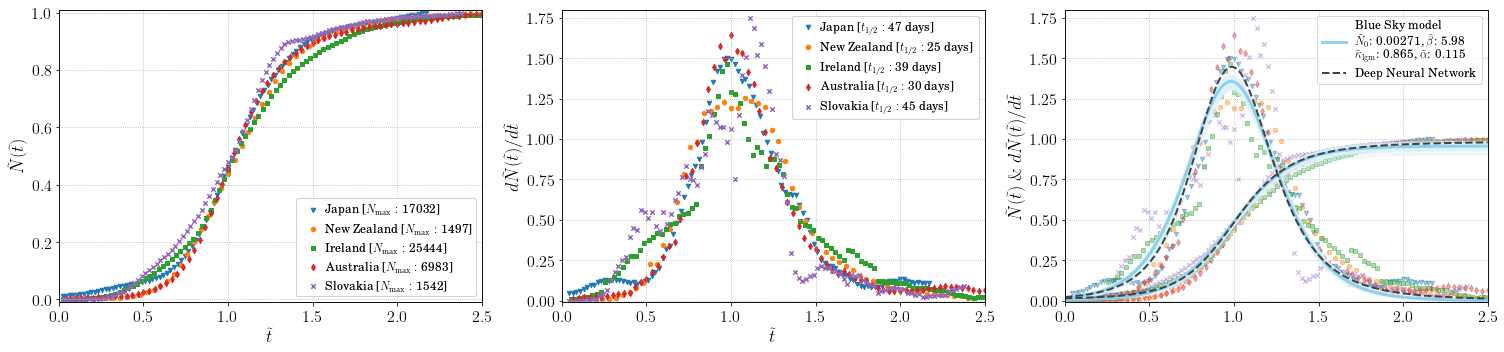

In [6]:
country = ['Japan', 'New Zealand', 'Ireland', 'Australia', 'Slovakia']
startdate = ['2020-3-1', '2020-3-10', '2020-3-10', '2020-3-1', '2020-3-1']
datet_max = ['2020-6-10', '2020-5-15', '2020-7-1', '2020-5-15', '2020-6-15']
markers = ['v', 'o', 's', 'd', 'x']

fig = plt.figure(figsize=(21,5))
plt, fit_1, covar_1, spline_t1 = analyze(countries, country, startdate, datet_max, markers, plt)

x_p = np.linspace(0,2.5,1000000)
y_p = interpolate.splev(x_p, spline_t1, der=0)
y_d = interpolate.splev(x_p, spline_t1, der=1)
data = np.vstack((x_p, y_p, y_d))
np.savetxt('data/type1-BSM.txt', data)
t_fact_1 = x_p[argrelextrema(y_d, np.greater)[0]][0]

data = np.loadtxt('data/type1-DNN.txt')
spline_t1a = interpolate.splrep(data[0], data[1])
t_fact_1a = data[0][argrelextrema(data[2], np.greater)[0]][0]


plt.subplot(1,3,3)
plt.plot(data[0], data[1], color='#434343', linestyle='dashed', linewidth=2, alpha=1, label='Deep Neural Network')
plt.plot(data[0], data[2], color='#434343', linestyle='dashed', linewidth=2, alpha=1)
plt.legend(fontsize=12, loc='upper right')

ax = fig.axes
ax[0].set_ylim([-0.01,1.8])
ax[1].set_ylim([-0.01,1.01])
ax[2].set_ylim([-0.01,1.8])
plt.tight_layout()
plt.savefig('../plots/universal_1_BSM.pdf', facecolor='white', dpi=300)
plt.show()

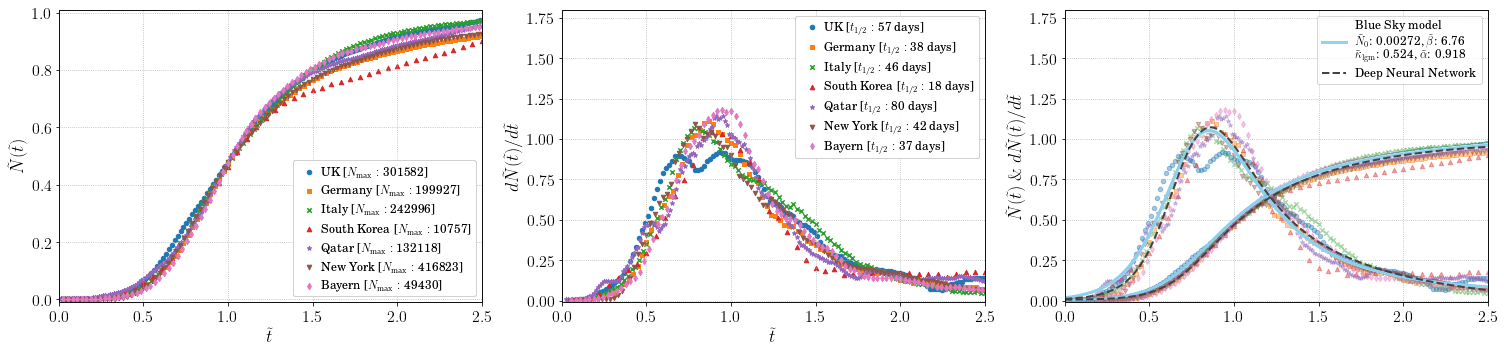

In [5]:
country = ['UK', 'Germany', 'Italy', 'South Korea', 'Qatar', 'New York', 'Bayern']
startdate = ['2020-3-1','2020-3-1', '2020-2-20', '2020-2-18', '2020-3-20', '2020-3-5', '2020-3-1']
datet_max = ['2020-8-1', '2020-7-15', '2020-7-15', '2020-5-1', '2020-11-1', '2020-8-1', '2020-7-15']
markers = ['o', 's', 'x', '^', '*', 'v', 'd']

fig = plt.figure(figsize=(21,5))
plt, fit_2, covar_2, spline_t2 = analyze(countries, country, startdate, datet_max, markers, plt)

x_p = np.linspace(0,2.5,100000)
y_p = interpolate.splev(x_p, spline_t2, der=0)
y_d = interpolate.splev(x_p, spline_t2, der=1)
data = np.vstack((x_p, y_p, y_d))
np.savetxt('data/type2-BSM.txt', data)
t_fact_2 = x_p[argrelextrema(y_d, np.greater)[0]][0]

data = np.loadtxt('data/type2-DNN.txt')
spline_t2a = interpolate.splrep(data[0], data[1])
t_fact_2a = data[0][argrelextrema(data[2], np.greater)[0]][0]

plt.subplot(1,3,3)
plt.plot(data[0], data[1], color='#434343', linestyle='dashed', linewidth=2, alpha=1, label='Deep Neural Network')
plt.plot(data[0], data[2], color='#434343', linestyle='dashed', linewidth=2, alpha=1)
plt.legend(fontsize=12, loc='upper right')


ax = fig.axes
ax[0].set_ylim([-0.01,1.8])
ax[1].set_ylim([-0.01,1.01])
ax[2].set_ylim([-0.01,1.8])
plt.tight_layout()
plt.savefig('../plots/universal_2_BSM.pdf', facecolor='white', dpi=300)
plt.show()